In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "ms",
    "timezone": "auto",
    "forecast_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Save to CSV
csv_filename = "london_hourly_weather.csv"
hourly_dataframe.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

print(hourly_dataframe)

Coordinates 51.5°N -0.12000012397766113°E
Elevation 23.0 m asl
Timezone b'Europe/London' None
Timezone difference to GMT+0 0 s
CSV saved: london_hourly_weather.csv
                         date  temperature_2m  relative_humidity_2m  \
0   2025-02-14 00:00:00+00:00       37.013000                  65.0   
1   2025-02-14 01:00:00+00:00       36.563000                  68.0   
2   2025-02-14 02:00:00+00:00       36.382999                  70.0   
3   2025-02-14 03:00:00+00:00       36.022999                  73.0   
4   2025-02-14 04:00:00+00:00       35.572998                  78.0   
..                        ...             ...                   ...   
163 2025-02-20 19:00:00+00:00       47.225300                  86.0   
164 2025-02-20 20:00:00+00:00       47.135300                  88.0   
165 2025-02-20 21:00:00+00:00       46.955299                  90.0   
166 2025-02-20 22:00:00+00:00       46.775299                  92.0   
167 2025-02-20 23:00:00+00:00       46.685303          

In [2]:
import pandas as pd
fut_df = pd.read_csv(csv_filename)

In [3]:
fut_df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-02-14 00:00:00+00:00,37.013000,65.0,26.337940,2.193171,65.772260,4.7
1,2025-02-14 01:00:00+00:00,36.563000,68.0,27.001110,1.878829,64.798920,4.6
2,2025-02-14 02:00:00+00:00,36.383000,70.0,27.532547,1.969772,66.037506,4.1
3,2025-02-14 03:00:00+00:00,36.023000,73.0,28.208029,2.088061,73.300674,4.6
4,2025-02-14 04:00:00+00:00,35.572998,78.0,29.392601,2.088061,73.300674,4.6


In [4]:
fut_df.rename(columns={'date': 'Time'}, inplace=True)
fut_df['Time'] = pd.to_datetime(fut_df['Time'])
fut_df['Year']=fut_df['Time'].dt.year
fut_df['Month']=fut_df['Time'].dt.month

In [5]:
fut_df['Hour'] = fut_df['Time'].dt.hour

In [6]:
fut_df

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour
0,2025-02-14 00:00:00+00:00,37.013000,65.0,26.337940,2.193171,65.772260,4.7,2025,2,0
1,2025-02-14 01:00:00+00:00,36.563000,68.0,27.001110,1.878829,64.798920,4.6,2025,2,1
2,2025-02-14 02:00:00+00:00,36.383000,70.0,27.532547,1.969772,66.037506,4.1,2025,2,2
3,2025-02-14 03:00:00+00:00,36.023000,73.0,28.208029,2.088061,73.300674,4.6,2025,2,3
4,2025-02-14 04:00:00+00:00,35.572998,78.0,29.392601,2.088061,73.300674,4.6,2025,2,4
...,...,...,...,...,...,...,...,...,...,...
163,2025-02-20 19:00:00+00:00,47.225300,86.0,43.251785,2.687006,135.000100,6.6,2025,2,19
164,2025-02-20 20:00:00+00:00,47.135300,88.0,43.764282,2.549510,131.820080,6.3,2025,2,20
165,2025-02-20 21:00:00+00:00,46.955300,90.0,44.175460,2.483948,130.100850,5.9,2025,2,21
166,2025-02-20 22:00:00+00:00,46.775300,92.0,44.574280,2.561250,128.659840,5.9,2025,2,22


In [7]:
import numpy as np
min_year = fut_df['Year'].min()
max_year = fut_df['Year'].max()
fut_df['Month_sin'] = np.sin(2 * np.pi * fut_df['Month'] / 12)
fut_df['Month_cos'] = np.cos(2 * np.pi * fut_df['Month'] / 12)

In [8]:
fut_df['Day'] = fut_df['Time'].dt.day
fut_df['Day_sin'] = np.sin(2 * np.pi * fut_df['Day'] / 31) 
fut_df['Day_cos'] = np.cos(2 * np.pi * fut_df['Day'] / 31)
fut_df['Hour_sin'] = np.sin(2 * np.pi * fut_df['Hour'] / 24) 
fut_df['Hour_cos'] = np.cos(2 * np.pi * fut_df['Hour'] / 24)

In [9]:
fut_df.head()

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour,Month_sin,Month_cos,Day,Day_sin,Day_cos,Hour_sin,Hour_cos
0,2025-02-14 00:00:00+00:00,37.013000,65.0,26.337940,2.193171,65.772260,4.7,2025,2,0,0.866025,0.5,14,0.299363,-0.954139,0.000000,1.000000
1,2025-02-14 01:00:00+00:00,36.563000,68.0,27.001110,1.878829,64.798920,4.6,2025,2,1,0.866025,0.5,14,0.299363,-0.954139,0.258819,0.965926
2,2025-02-14 02:00:00+00:00,36.383000,70.0,27.532547,1.969772,66.037506,4.1,2025,2,2,0.866025,0.5,14,0.299363,-0.954139,0.500000,0.866025
3,2025-02-14 03:00:00+00:00,36.023000,73.0,28.208029,2.088061,73.300674,4.6,2025,2,3,0.866025,0.5,14,0.299363,-0.954139,0.707107,0.707107
4,2025-02-14 04:00:00+00:00,35.572998,78.0,29.392601,2.088061,73.300674,4.6,2025,2,4,0.866025,0.5,14,0.299363,-0.954139,0.866025,0.500000


In [10]:
""" import pickle
with open('random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
 """
import pickle
with open("random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

In [11]:
fut_df.rename(columns={"relative_humidity_2m":"relativehumidity_2m", "dew_point_2m":"dewpoint_2m", "wind_speed_10m":"windspeed_10m", "wind_direction_10m":"winddirection_10m", "wind_gusts_10m":"windgusts_10m"}, inplace=True)

In [12]:
pred_df = fut_df.drop(columns=["Time","Day","Year","Month","Hour"])
y_pred = model.predict(pred_df)

In [13]:
y_pred

array([0.269466  , 0.24504188, 0.17075213, 0.16713011, 0.14070652,
       0.12204168, 0.1427601 , 0.13961728, 0.13596131, 0.17809073,
       0.323393  , 0.421714  , 0.426116  , 0.34002233, 0.29774933,
       0.34013333, 0.410604  , 0.35054   , 0.26083767, 0.30527533,
       0.230022  , 0.282118  , 0.289033  , 0.31203367, 0.30061367,
       0.30562633, 0.18868311, 0.1734084 , 0.17013511, 0.18526924,
       0.16654211, 0.17850631, 0.1739829 , 0.1685253 , 0.14300107,
       0.14494823, 0.18251367, 0.18619533, 0.19786633, 0.22753333,
       0.294747  , 0.20948533, 0.18200067, 0.275938  , 0.26474633,
       0.29399367, 0.32980933, 0.31182133, 0.36316033, 0.22208733,
       0.18683392, 0.16422033, 0.15942683, 0.16103153, 0.19871379,
       0.24059533, 0.235588  , 0.18587167, 0.16221433, 0.170807  ,
       0.291073  , 0.15644   , 0.240455  , 0.52779933, 0.19538183,
       0.12627088, 0.1184538 , 0.14031883, 0.1322195 , 0.1527082 ,
       0.15276323, 0.16067856, 0.14405616, 0.15373471, 0.13868

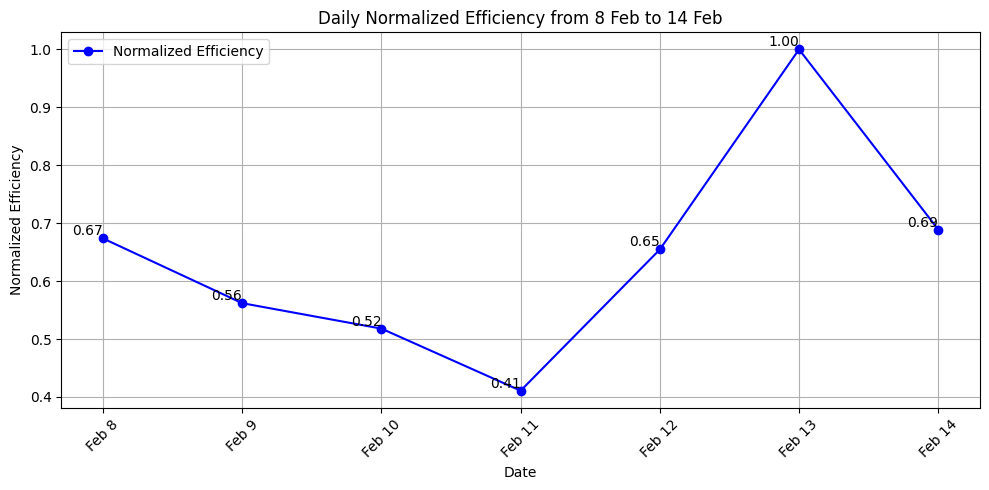

'normalized_efficiency_plot.png'

In [14]:
import numpy as np
import matplotlib.pyplot as plt

efficiency_values = y_pred

daily_efficiency = efficiency_values.reshape(-1, 24).sum(axis=1)
normalized_efficiency = daily_efficiency / daily_efficiency.max()  # Normalize

dates = [f"Feb {i}" for i in range(8, 15)]

plt.figure(figsize=(10, 5))
plt.plot(dates, normalized_efficiency, marker='o', linestyle='-', color='b', label="Normalized Efficiency")

for i, txt in enumerate(normalized_efficiency):
    plt.text(dates[i], normalized_efficiency[i], f"{txt:.2f}", ha='right', va='bottom', fontsize=10)

plt.xlabel("Date")
plt.ylabel("Normalized Efficiency")
plt.title("Daily Normalized Efficiency from 8 Feb to 14 Feb")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
image_path = "normalized_efficiency_plot.png"
plt.savefig(image_path, dpi=300)
plt.show()

image_path


In [15]:
df_efficiency = pd.DataFrame({
    "Date": dates,
    "Normalized_Efficiency": normalized_efficiency
})

# Save to CSV
csv_path = "efficiency_data.csv"
df_efficiency.to_csv(csv_path, index=False)

# Display the table
print(df_efficiency)

csv_path

     Date  Normalized_Efficiency
0   Feb 8               0.673675
1   Feb 9               0.561923
2  Feb 10               0.518005
3  Feb 11               0.410859
4  Feb 12               0.654618
5  Feb 13               1.000000
6  Feb 14               0.689028


'efficiency_data.csv'

In [16]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "ms",
    "timezone": "auto",
    "forecast_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Save to CSV
csv_filename = "london_hourly_weather.csv"
hourly_dataframe.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

print(hourly_dataframe)

Coordinates 51.5°N -0.12000012397766113°E
Elevation 23.0 m asl
Timezone b'Europe/London' None
Timezone difference to GMT+0 0 s
CSV saved: london_hourly_weather.csv
                         date  temperature_2m  relative_humidity_2m  \
0   2025-02-14 00:00:00+00:00       37.013000                  65.0   
1   2025-02-14 01:00:00+00:00       36.563000                  68.0   
2   2025-02-14 02:00:00+00:00       36.382999                  70.0   
3   2025-02-14 03:00:00+00:00       36.022999                  73.0   
4   2025-02-14 04:00:00+00:00       35.572998                  78.0   
..                        ...             ...                   ...   
163 2025-02-20 19:00:00+00:00       47.225300                  86.0   
164 2025-02-20 20:00:00+00:00       47.135300                  88.0   
165 2025-02-20 21:00:00+00:00       46.955299                  90.0   
166 2025-02-20 22:00:00+00:00       46.775299                  92.0   
167 2025-02-20 23:00:00+00:00       46.685303          